# Mood Recognition Model


First of all import the necessary libraries 

In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow.keras
import tensorflow
import math
from google.colab.patches import cv2_imshow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt
%matplotlib inline 

In [ ]:
device_name = tensorflow.test.gpu_device_name() #in the notebook settings do enable gpu while running the code
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing the fer2013 dataset which we are using to train the model here

In [ ]:
data = pd.read_csv('/content/drive/My Drive/fer2013.csv')

In [ ]:
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [ ]:
data['Usage'].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [ ]:
lst2=[]
for i in range(data.shape[0]):
  lst=[]
  for j in (data["pixels"][i]).split():
    lst.append(int(j))
  lst2.append(lst)
x_data = np.array(lst2)
print(x_data.shape)

(35887, 2304)


Reshape the data into suitable form

In [ ]:
x_data=x_data.reshape((35887,48,48,1))

y_data=np.array(data["emotion"])


In [ ]:
x_train=[]
y_train=[]
x_val = []
y_val = []
x_test=[]
y_test=[]
for i in range(x_data.shape[0]):
  if data["Usage"][i]=="Training":
    x_train.append(x_data[i])
    y_train.append(y_data[i])
  elif data["Usage"][i] == "PublicTest":
    x_val.append(x_data[i])
    y_val.append(y_data[i])
  else:
    x_test.append(x_data[i])
    y_test.append(y_data[i])
x_train=np.array(x_train)
y_train=np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)
x_test=np.array(x_test)
y_test=np.array(y_test)
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(28709, 48, 48, 1) (28709,) (3589, 48, 48, 1) (3589,)


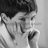

In [ ]:
i=3
cv2_imshow(x_train[i])

Declare the necessary hyperparameters for training our model

In [ ]:
my_learning_rate=0.0008
iters=120
batch_len=64
validation_split_ratio=0.2

Data Augmentation  
Here ramndomly selected images from our training data will be flipped, rotated or zoomed. This will help increase the variety of data and thus improve model the model and preventing overfitting.

In [ ]:
data_augmentation = tensorflow.keras.Sequential(
  [
    tensorflow.keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(48,48,1)),
    tensorflow.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tensorflow.keras.layers.experimental.preprocessing.RandomZoom(0.05),
  ]
)

Creating the model  
In this model there are 8 CNN layers with filters 16, 32, 64, 128 each 2 times. After 2 CNN layers there is a max pooling layer.  This is followed by 4 fully connected layers of units 128, 64, 32 and finally 7  i.e the output layer. In order to prevent overfitting there are dropouts of 0.25 rate and batch normalization in between.

In [ ]:
model = Sequential([  
        tensorflow.keras.layers.InputLayer(input_shape=(48, 48, 1)),
        data_augmentation,
        Conv2D(16, kernel_size=(3, 3), activation='relu', padding ='same'),
        Conv2D(16, kernel_size=(3, 3), activation='relu', padding = 'same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding ='same'),
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding ='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding ='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding ='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding ='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding ='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation="relu"),
        Dropout(0.25),
        Dense(64, activation = "relu"),
        Dropout(0.25),
        Dense(32,activation='relu'),
        Dropout(0.25),
        Dense(7,activation='softmax')
        ])

Here we finally compile our model and train it. We have used Adam optimizer and sparse categorical cross entropy as loss. 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 48, 48, 16)        160       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 48, 48, 16)        2320      
_________________________________________________________________
batch_normalization_8 (Batch (None, 48, 48, 16)        64        
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 24, 24, 32)       

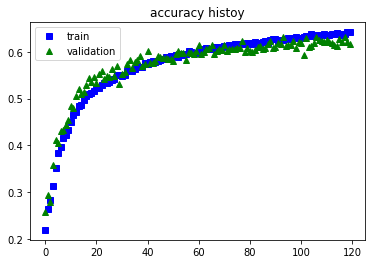

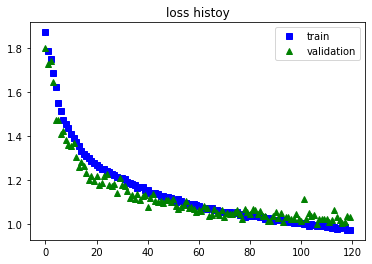

In [ ]:
opt=tensorflow.keras.optimizers.Adam(learning_rate=my_learning_rate)
checkpoint = keras.callbacks.ModelCheckpoint(filepath = '/content/drive/MyDrive/Moodify_weights.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics='accuracy')
print(model.summary())
History=model.fit(x_train,y_train,batch_size=batch_len,epochs=iters,verbose=2,validation_data = (x_val,y_val), callbacks=[checkpoint])
index=[i for i in range(len(History.history['accuracy']))]
plt.title("accuracy histoy")
plt.plot(index,History.history['accuracy'],'bs',label='train')
plt.plot(index,History.history['val_accuracy'],'g^',label='validation')
plt.legend(loc="upper left")
plt.show()
plt.title("loss histoy")
plt.plot(index,History.history['loss'],'bs',label='train')
plt.plot(index,History.history['val_loss'],'g^',label='validation')
plt.legend(loc="upper right")
plt.show()

In [ ]:
model.load_weights("/content/drive/MyDrive/Moodify_weights.hdf5")
model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics='accuracy')
model.evaluate(x_test,y_test)

113/113 [==============================] - 1s 4ms/step - loss: 0.9403 - accuracy: 0.6420


[0.9403234124183655, 0.6419615745544434]